<a href="https://colab.research.google.com/github/Jayku88/DeepLearningWorkshop_MGUniversity/blob/main/TransformerInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

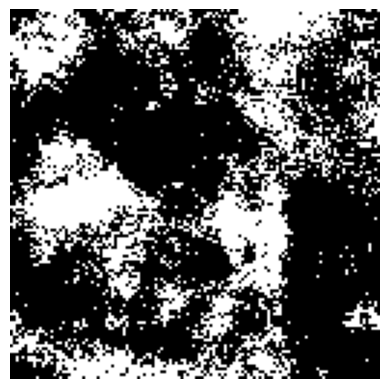

In [ ]:
from transformers import SegformerConfig, SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Feature Extractor
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# 2. Load new config
config = SegformerConfig.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
config.num_labels = 2

# 3. Initialize new model
model = SegformerForSemanticSegmentation(config)

# (Optional) Load encoder weights
pretrained_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model.segformer.load_state_dict(pretrained_model.segformer.state_dict())

# 4. Load and preprocess image
#image = Image.open('10378780_15_0_0.tiff').convert('RGB')
#image = Image.open('16078870_15_1_4.tiff').convert('RGB')
image = Image.open('876466_sat_0_0.jpg').convert('RGB')

inputs = feature_extractor(images=image, return_tensors="pt")

# 5. Inference
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, 2, height, width)
segmentation = logits.argmax(dim=1)[0].cpu().numpy()

# 6. Visualization
plt.imshow(segmentation, cmap='gray')  # Use gray for binary
plt.axis('off')
plt.show()


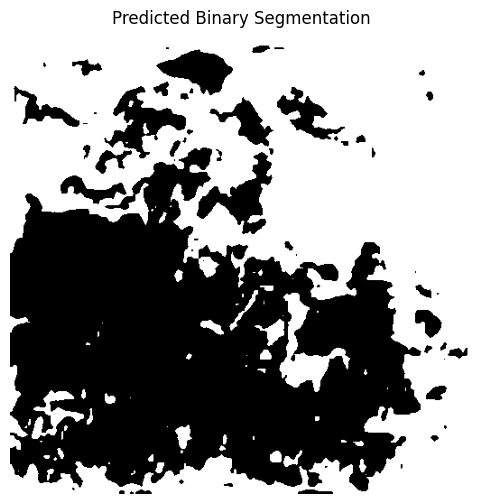

In [ ]:
# Install if needed
# !pip install transformers

from transformers import UperNetForSemanticSegmentation, AutoImageProcessor
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 1. Load pre-trained UPerNet-Swin model
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-base")

# 2. Modify for binary segmentation
model.config.num_labels = 2  # Only 2 classes


model.decode_head.classifier = nn.Conv2d(
    model.decode_head.classifier.in_channels,
    2,
    kernel_size=1
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 3. Load feature extractor
processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-base")
processor.do_resize = False  # Already 512x512

# 4. Load and preprocess your 512x512 image
#image_path = '10378780_15_0_0.tiff'  # Update this path
#image_path = '16078870_15_1_4.tiff'
image_path = '876466_sat_0_0.jpg'
image = Image.open(image_path).convert('RGB')

inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# 5. Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # (batch_size, 2, h', w')

# 6. Upsample logits back to 512x512
upsampled_logits = F.interpolate(
    logits, size=(512, 512), mode='bilinear', align_corners=False
)

# 7. Get segmentation map (0 = background, 1 = road)
segmentation = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

# 8. Visualize result
plt.figure(figsize=(6,6))
plt.imshow(segmentation, cmap='gray')
plt.axis('off')
plt.title('Predicted Binary Segmentation')
plt.show()
